In [26]:
from operator import itemgetter

import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

from caveclient import CAVEclient
from standard_transform import minnie_transform_nm

import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

In [27]:
MINNIE_DATASTACK = "minnie65_public_v343"
# client = CAVEclient(MINNIE_DATASTACK)
client = CAVEclient(MINNIE_DATASTACK, desired_resolution=[1, 1, 1])

In [28]:
nm_transform = minnie_transform_nm()
nm_transform

Transformation Sequence:
	Rotate with params ('z', 5) and {'degrees': True}
	Translate by [      0.         -396671.03221028       0.        ]
	Scale by [[0.001 0.001 0.001]]

In [48]:
# LAYER_BOUNDARIES = [100, 375, 550, 750, 800]
LAYER_BOUNDARIES = [90, 255, 380, 550, 700]
# LAYER_BOUNDARIES = [106.80615154, 276.21908419, 411.8631847 , 552.04973966, 768.58049474]
LAYER_NAMES = ["2/3", "4", "5", "6"]

def add_layer_lines(ax):
    for i, depth in enumerate(LAYER_BOUNDARIES):
        ax.axhline(depth, xmin=0.02, xmax=0.98, color="red", linestyle="dashed")
        ax.text(x=1, y=depth, s=f"{depth:.0f} µm", ha="left", va="center", color="red", fontsize=10, transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData))

        if i < len(LAYER_NAMES):
            layer = LAYER_NAMES[i]
            layer_text_y = depth + (LAYER_BOUNDARIES[i+1]-depth)/2
            ax.text(x=1, y=layer_text_y, s=f"L{layer}", ha="left", va="center", color="darkred", fontweight="bold", transform=mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData))

def get_layer_min_max_depth(layer):
    if type(layer) is int:
        layer = str(layer)
    
    # if layer == "23" or layer == "2/3":
    #     return LAYER_BOUNDARIES[LAYER_NAMES.index("2")], LAYER_BOUNDARIES[LAYER_NAMES.index("3")+1]
    
    if layer in LAYER_NAMES:
        i = LAYER_NAMES.index(layer)
        return LAYER_BOUNDARIES[i], LAYER_BOUNDARIES[i+1]
    
    raise ValueError(f"Bad layer: {layer}")

def is_in_layer(pos, layer, boundary_padding=25):
    min_depth, max_depth = get_layer_min_max_depth(layer)
    min_depth -= boundary_padding
    max_depth += boundary_padding

    if isinstance(pos, pd.Series):
        return pos.apply(lambda p: min_depth <= p[1] <= max_depth)
    elif isinstance(pos, np.ndarray) and len(pos.shape) == 2:
        return (min_depth <= pos[:,1]) & (pos[:,1] <= max_depth)
    else:
        return min_depth <= pos[1] <= max_depth

def is_in_central_column(pos):
    return 575 <= pos[0] <= 750 and 775 <= pos[2] <= 950

In [42]:
nucleus_neuron_svm = client.materialize.query_table("nucleus_neuron_svm")

Table Owner Notice on nucleus_neuron_svm: Please cite https://doi.org/10.1101/2022.07.20.499976 when using this table.


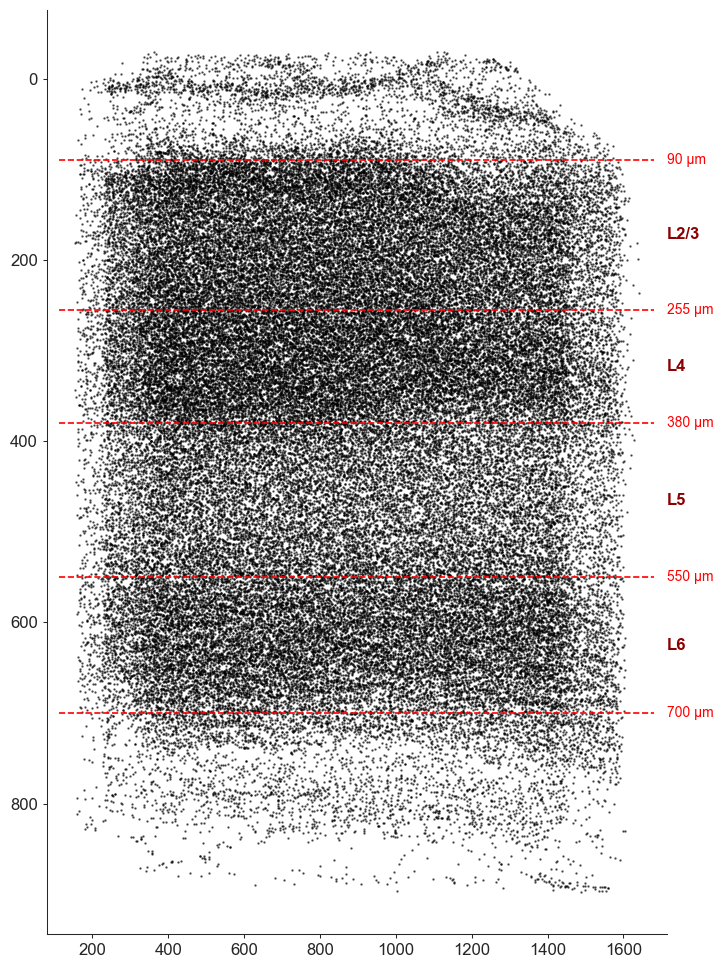

In [49]:
neuron_pos_nm = np.vstack(nucleus_neuron_svm.pt_position.values[nucleus_neuron_svm.cell_type == "neuron"])
neuron_pos_microns = nm_transform.apply(neuron_pos_nm)

fig, ax = plt.subplots(figsize=(8, 12))
ax.scatter(neuron_pos_microns[:, 0], neuron_pos_microns[:, 1], s=1, color="black", alpha=0.5)
# ax.scatter(neuron_pos_nm[:, 0], neuron_pos_nm[:, 1], s=1, color="black", alpha=0.5)
ax.invert_yaxis()
add_layer_lines(ax)

In [35]:
proof_table = client.materialize.query_table("proofreading_status_public_release")
axo_proof_pt_root_ids = proof_table.pt_root_id.values[proof_table.status_axon.isin(["extended"])]
den_proof_pt_root_ids = proof_table.pt_root_id.values[proof_table.status_dendrite.isin(["clean", "extended"])]
proof_pt_root_ids = np.intersect1d(axo_proof_pt_root_ids, den_proof_pt_root_ids)

proof_table.head()

,id,valid,pt_supervoxel_id,pt_root_id,valid_id,status_dendrite,status_axon,pt_position
0,4,t,91077153340676495,864691135355207375,864691135355207375,extended,non,"[765696.0, 839552.0, 913800.0]"
1,7,t,91570559116360958,864691136602027473,864691136602027473,extended,non,"[779456.0, 864512.0, 888200.0]"
2,8,t,90444453118345856,864691135866846742,864691135866846742,extended,non,"[747072.0, 857152.0, 912440.0]"
3,9,t,89741246779911895,864691135445832338,864691135445832338,extended,non,"[725248.0, 871616.0, 930040.0]"
4,13,t,91499640750531825,864691135569255558,864691135569255558,extended,non,"[776448.0, 848256.0, 927000.0]"


In [36]:
soma_df = client.materialize.query_table("aibs_soma_nuc_metamodel_preds_v117")
soma_df = soma_df.drop_duplicates("pt_root_id", keep=False)
# soma_df["pt_position_microns"] = nm_transform.apply_(soma_df["pt_position"])
soma_df["pt_position_microns"] = list(nm_transform.column_apply(soma_df["pt_position"], return_array=True))
soma_df

,id,valid,target_id,classification_system,cell_type,id_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,pt_position_microns
1,4509,t,487329,aibs_neuronal,MC,487329,t,295.937638,105279407463397326,864691135975935434,"[1178176.0, 474496.0, 869800.0]","[nan, nan, nan]","[nan, nan, nan]","[1132.3376333081478, 178.7041716229213, 869.80..."
2,4693,t,106662,aibs_neuronal,23P,106662,t,230.148178,79524515478544304,864691136084076652,"[428224.0, 476992.0, 776560.0]","[nan, nan, nan]","[nan, nan, nan]","[385.0218863509487, 115.82805000426656, 776.56..."
3,5061,t,271350,aibs_neuronal,6P-CT,271350,t,305.328128,87351114324194368,864691135937342005,"[655680.0, 943872.0, 835000.0]","[nan, nan, nan]","[nan, nan, nan]","[570.9210744260782, 600.755527271752, 835.0000..."
4,8652,t,456040,aibs_neuronal,MC,456040,t,257.463910,101129507251445952,864691136084057196,"[1058176.0, 530112.0, 959520.0]","[nan, nan, nan]","[nan, nan, nan]","[1007.9470157484845, 223.64984682227282, 959.5..."
5,8744,t,407408,aibs_neuronal,6P-CT,407408,t,244.599357,96711325195350282,864691134917402634,"[929600.0, 978432.0, 729680.0]","[nan, nan, nan]","[nan, nan, nan]","[840.7866236580102, 659.0577170912412, 729.680..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86910,86911,t,394515,aibs_nonneuronal,astrocyte,394515,t,190.166303,96347181023422242,864691136050803443,"[918016.0, 611264.0, 823840.0]","[nan, nan, nan]","[nan, nan, nan]","[861.2475040284874, 292.2772900583024, 823.840..."
86912,86913,t,329229,aibs_neuronal,4P,329229,t,271.882322,92547130727975969,864691135740183915,"[808704.0, 607040.0, 626400.0]","[nan, nan, nan]","[nan, nan, nan]","[752.7196150480487, 278.54219510233094, 626.40..."
86913,86914,t,589184,aibs_nonneuronal,oligo,589184,t,124.472852,110987178548578816,864691135081676023,"[1343680.0, 710784.0, 885360.0]","[nan, nan, nan]","[nan, nan, nan]","[1276.6179844787655, 428.51764849333216, 885.3..."
86914,86915,t,256280,aibs_neuronal,23P,256280,t,354.738012,87546415009833381,864691136966016974,"[663232.0, 473024.0, 807920.0]","[nan, nan, nan]","[nan, nan, nan]","[619.4814439473164, 132.35744623388018, 807.92..."


In [ ]:
EXCITATORY_NEURON_CELL_TYPE = ["23P", "4P", "5P-ET", "5P-IT", "5P-NP", "6P-IT", "6P-CT"]
INHIBITORY_NEURON_CELL_TYPE = ["BC", "BPC", "MC", "NGC"]

In [ ]:
soma_df.cell_type.value_counts()

23P          17091
4P           12812
6P-IT         9831
5P-IT         8395
astrocyte     6275
6P-CT         5243
oligo         4816
BC            2862
microglia     2523
MC            2156
OPC           1443
5P-ET         1363
BPC           1361
NGC            570
pericyte       457
5P-NP          427
Name: cell_type, dtype: int64

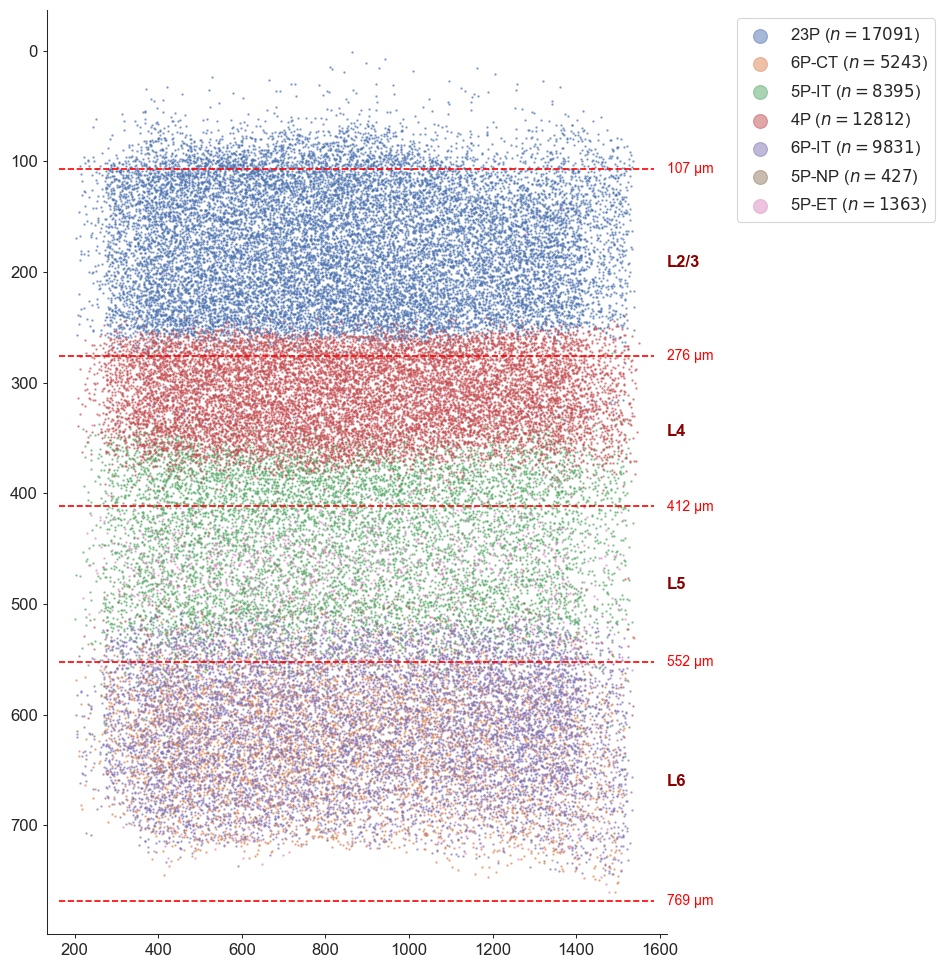

In [38]:
fig, ax = plt.subplots(figsize=(8, 12))

for cell_type in soma_df.cell_type.unique():
    if cell_type not in EXCITATORY_NEURON_CELL_TYPE: continue
    pos = soma_df.pt_position_microns[soma_df.cell_type == cell_type]
    x = pos.apply(itemgetter(0))
    y = pos.apply(itemgetter(1))
    ax.scatter(x, y, label=f"{cell_type} ($n = {len(pos)}$)", s=1, alpha=0.5)

ax.legend(loc="upper left", bbox_to_anchor=(1.1, 1), bbox_transform=ax.transAxes, markerscale=10)
ax.invert_yaxis()
add_layer_lines(ax)

In [50]:
root_id_to_cell_type = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.cell_type.values)
root_id_to_soma_pos = pd.Series(index=soma_df.pt_root_id.values, data=soma_df.pt_position_microns.values)

# Estimate connection probabilities based on all somas

In [51]:
def matches_or_in(series, val):
    if type(val) is str:
        return series == val
    else:
        return series.isin(val)

def get_cell_type_str(cell_type):
    if cell_type == EXCITATORY_NEURON_CELL_TYPE:
        return "E"
    elif cell_type == INHIBITORY_NEURON_CELL_TYPE:
        return "I"
    elif type(cell_type) is not str:
        return str(cell_type)
    else:
        return cell_type

In [52]:
is_neuron = is_neuron = soma_df.classification_system == "aibs_neuronal"
l_23 = is_in_layer(soma_df.pt_position_microns, "2/3") & is_neuron
np.sum(l_23 & matches_or_in(soma_df.cell_type, EXCITATORY_NEURON_CELL_TYPE)) / np.sum(l_23)

0.8968395945140131

In [53]:
pre_cell_type = EXCITATORY_NEURON_CELL_TYPE
pre_layer = "2/3"
# post_cell_type = EXCITATORY_NEURON_CELL_TYPE
# post_cell_type = "BC"
post_cell_type = "MC"
# post_cell_type = "BPC"
post_layer = "2/3"

pre_population_soma_df_mask = matches_or_in(soma_df.cell_type, pre_cell_type) \
                                & is_in_layer(soma_df.pt_position_microns, pre_layer) \
                                & soma_df.pt_root_id.isin(axo_proof_pt_root_ids) \
                                & soma_df.pt_position_microns.apply(is_in_central_column)
post_population_soma_df_mask = matches_or_in(soma_df.cell_type, post_cell_type) \
                                & is_in_layer(soma_df.pt_position_microns, post_layer)
                                # & soma_df.pt_root_id.isin(den_proof_pt_root_ids) \

print(f"n pre = {pre_population_soma_df_mask.sum()}, n post = {post_population_soma_df_mask.sum()}")

pre_root_ids = soma_df.pt_root_id.values[pre_population_soma_df_mask]
post_population_root_ids = soma_df.pt_root_id.values[post_population_soma_df_mask]
post_population_soma_pos = np.vstack(soma_df.pt_position_microns.values[post_population_soma_df_mask])
pre_soma_y = soma_df.pt_position_microns[pre_population_soma_df_mask].apply(lambda pos: pos[1])
cmap_norm = mpl.colors.Normalize(vmin=pre_soma_y.min(), vmax=pre_soma_y.max())

n pre = 6, n post = 465


In [54]:
all_axo_syn = client.materialize.synapse_query(pre_ids=pre_root_ids)
all_axo_syn["syn_pos_microns"] = list(nm_transform.column_apply(all_axo_syn["ctr_pt_position"], return_array=True))
all_axo_syn["soma_to_syn_dist_microns"] = all_axo_syn.apply(lambda row: np.linalg.norm(row["syn_pos_microns"] - root_id_to_soma_pos[row["pre_pt_root_id"]]), axis=1)
all_axo_syn.head()

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,syn_pos_microns,soma_to_syn_dist_microns
0,158004105,t,88961555126900279,864691135293126156,88961555126892864,864691136296663579,2520,"[703992.0, 703776.0, 780400.0]","[703800.0, 703888.0, 780240.0]","[703720.0, 703888.0, 780000.0]","[639.6942514899596, 365.8717007265001, 780.000...",166.367212
1,141136318,t,87413649249128378,864691135293126156,87413649249123571,864691135341043653,7528,"[658536.0, 709888.0, 888280.0]","[658504.0, 710312.0, 888160.0]","[658712.0, 710056.0, 888040.0]","[594.3199438969789, 368.0935239547435, 888.040...",170.320315
2,160773594,t,89379507253181421,864691135293126156,89379507253188522,864691135082015991,176,"[714896.0, 577576.0, 874360.0]","[715168.0, 577416.0, 874720.0]","[715216.0, 577448.0, 874480.0]","[662.1664778522363, 240.91478551840683, 874.48...",43.095707
3,406141849,t,109219713070307778,864691135293126156,109219644350806278,864691135941646498,2672,"[1293224.0, 463968.0, 730160.0]","[1293336.0, 463464.0, 729600.0]","[1293272.0, 463728.0, 729960.0]","[1247.934151317622, 178.0084244811539, 729.960...",610.660994
4,269920043,t,98395296375568083,864691135293126156,98395296375574409,864691135771714635,5372,"[978184.0, 832984.0, 859400.0]","[978656.0, 833024.0, 859560.0]","[978432.0, 833080.0, 859600.0]","[902.1010646750838, 518.5148145640636, 859.600...",397.084428


(81.23680467715407, 1607.6093462914318, 300.8879058767436, 54.359216210439584)

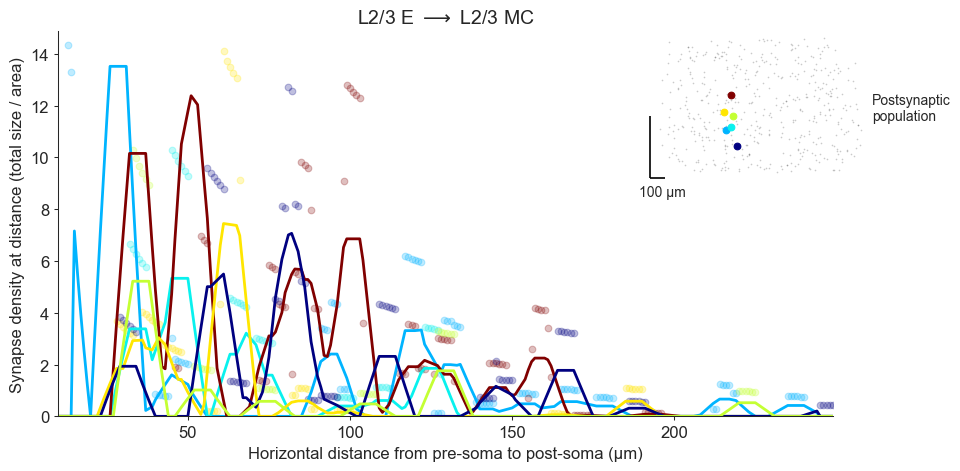

In [55]:
dist_range = np.arange(10, 250)
dist_window_radius_axon = 10 # Fudging this doesn't seem to affect probability curve
# dist_window_radius = 0.5
dist_window_radius = 3
cmap = plt.get_cmap("jet_r")
cmap_norm = mpl.colors.Normalize(vmin=pre_soma_y.min(), vmax=pre_soma_y.max())

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"L{pre_layer} {get_cell_type_str(pre_cell_type)} $\\longrightarrow$ L{post_layer} {get_cell_type_str(post_cell_type)}")
ax.set_xlabel("Horizontal distance from pre-soma to post-soma (µm)")
# ax.set_ylabel("Total synapse size at distance")
ax.set_ylabel("Synapse density at distance (total size / area)")
ax_inset = ax.inset_axes([0.75, 0.6, 0.3, 0.4])

# fig, ax_axon = plt.subplots(figsize=(10, 5))
# ax_axon.set_title(f"L{pre_layer} {get_cell_type_str(pre_cell_type)} axonal synapses")
# ax_axon.set_xlabel("Euclidean distance from soma to axonal synapse (µm)")
# ax_axon.set_ylabel("Normalized synapse density at distance")

y_max = 0

for this_root_id in all_axo_syn.pre_pt_root_id.unique():
    this_soma_pos = root_id_to_soma_pos[this_root_id]

    syn = all_axo_syn[all_axo_syn.pre_pt_root_id == this_root_id]
    post_population_soma_dist = np.linalg.norm((post_population_soma_pos - this_soma_pos)[:, ::2], axis=1) # ::2 = ignore middle (y) dimension
    syn_weight_at_axon_dist = np.zeros_like(dist_range, dtype=float)
    syn_weight_at_dist = np.zeros_like(dist_range, dtype=float)
    syn_density_at_dist = np.zeros_like(dist_range, dtype=float)

    for i, d in enumerate(dist_range):
        syn_within_dist = syn[np.abs(syn.soma_to_syn_dist_microns - d) <= dist_window_radius_axon]
        syn_weight_at_axon_dist[i] = np.nan if len(syn_within_dist) == 0 else syn_within_dist["size"].sum()

        # Compute soma-soma synapse density
        post_root_ids_within_dist = post_population_root_ids[np.abs(post_population_soma_dist - d) <= dist_window_radius]
        syn_within_dist = syn[syn.post_pt_root_id.isin(post_root_ids_within_dist)]
        syn_weight_at_dist[i] = np.nan if len(syn_within_dist) == 0 else syn_within_dist["size"].sum()
        area_of_annulus = np.pi * ((d+dist_window_radius)**2 - (d-dist_window_radius)**2)
        syn_density_at_dist[i] = np.nan if len(syn_within_dist) == 0 else syn_within_dist["size"].sum() / area_of_annulus
    
    total_syn_size = syn["size"].sum()
    syn_density_at_axon_dist = syn_weight_at_axon_dist / total_syn_size
        
    color = cmap(cmap_norm(this_soma_pos[1]))
    # ax_axon.plot(dist_range, syn_density_at_axon_dist, color=color, linewidth=2)
    # ax.plot(dist_range, syn_density_at_dist, color=color, linewidth=2)
    # ax.plot(dist_range, syn_weight_at_dist, color=color, linewidth=2)

    # metric_to_plot = syn_weight_at_dist
    metric_to_plot = syn_density_at_dist

    ax.scatter(dist_range, metric_to_plot, color=color, alpha=0.25)
    rolling_avg_r = 5
    y_rolling_avg = np.zeros_like(dist_range, dtype=float)
    # kernel = np.array([0]*rolling_avg_r + [1] + [0]*rolling_avg_r, dtype=float)
    kernel = np.ones(2*rolling_avg_r+1) / (2*rolling_avg_r+1) # Rolling average kernel
    # kernel = scipy.ndimage.gaussian_filter1d(kernel, sigma=3) # Gaussian kernel
    for i in range(rolling_avg_r, len(dist_range) - rolling_avg_r):
        y_rolling_avg[i] = np.nansum(metric_to_plot[i-rolling_avg_r:i+rolling_avg_r+1] * kernel)
    ax.plot(dist_range, y_rolling_avg, color=color, linewidth=2)
    if not np.all(np.isnan(y_rolling_avg)):
        y_max = max(y_max, np.nanmax(y_rolling_avg))

    ax_inset.scatter(this_soma_pos[0], this_soma_pos[1], color=color)

# ax_axon.set_xlim(dist_range.min(), dist_range.max())
# ax_axon.set_ylim(0, ax_axon.get_ylim()[1])

ax.set_xlim(dist_range.min(), dist_range.max())
if y_max > 0:
    ax.set_ylim(0, y_max*1.1)

ax_inset.scatter(post_population_soma_pos[:,0], post_population_soma_pos[:,1], color="black", s=0.1, alpha=0.25, zorder=0, label=f"{post_cell_type}")
ax_inset.invert_yaxis()
(xmin, xmax), (ymin, ymax) = ax_inset.get_xlim(), ax_inset.get_ylim()
ax_inset.vlines(x=xmin, ymin=ymin, ymax=ymin-100, color="black")
ax_inset.hlines(y=ymin, xmin=xmin, xmax=xmin+100, color="black")
ax_inset.text(0, 0, "100 µm", transform=ax_inset.transAxes, fontsize=10, va="top", ha="left")
ax_inset.text(1, 0.5, "Postsynaptic\npopulation", fontsize=10, transform=ax_inset.transAxes, va="center", ha="left")
ax_inset.axis("off")

In [154]:
# poroot_id_to_cell_type

0

In [178]:
np.unique(root_id_to_cell_type.values)

array(['23P', '4P', '5P-ET', '5P-IT', '5P-NP', '6P-CT', '6P-IT', 'BC',
       'BPC', 'MC', 'NGC', 'OPC', 'astrocyte', 'microglia', 'oligo',
       'pericyte'], dtype=object)

In [189]:
# Fraction of local outputs
local_dist = 200

cell_types = ["MC", "BC", "BPC", "23P", "4P", '5P-ET', '5P-IT', '5P-NP', '6P-CT', '6P-IT']

syn_frac_onto_cell_type = {get_cell_type_str(cell_type): [] for cell_type in cell_types}

for this_root_id in all_axo_syn.pre_pt_root_id.unique():
    this_soma_pos = root_id_to_soma_pos[this_root_id]
    syn = all_axo_syn[all_axo_syn.pre_pt_root_id == this_root_id]
    local_syn = syn[syn.post_pt_root_id.apply(lambda post: post in root_id_to_soma_pos and np.linalg.norm((root_id_to_soma_pos[post] - this_soma_pos)[::2]) < local_dist)]

    post_cell_type_counts = local_syn.post_pt_root_id.apply(root_id_to_cell_type.get).value_counts()
    tot = post_cell_type_counts.values.sum()

    for cell_type in cell_types:
        if type(cell_type) is str:
            count = post_cell_type_counts.get(cell_type, 0)
        else:
            count = sum(post_cell_type_counts.get(c, 0) for c in cell_type)
        
        cell_type_str = get_cell_type_str(cell_type)
        syn_frac_onto_cell_type[cell_type_str].append(count/tot)
        # syn_frac_onto_cell_type[cell_type_str].append(count)
        # print(f"{cell_type_str}: {count}/{tot} ({count/tot*100:.1f}%)")

    # post_population_soma_dist = np.linalg.norm((post_population_soma_pos - this_soma_pos)[:, ::2], axis=1) # ::2 = ignore middle (y) dimension
    # syn_weight_at_axon_dist = np.zeros_like(dist_range, dtype=float)
    # syn_weight_at_dist = np.zeros_like(dist_range, dtype=float)
    # syn_density_at_dist = np.zeros_like(dist_range, dtype=float)

    # local_syn = syn[np.abs(syn.soma_to_syn_dist_microns - d) <= dist_window_radius_axon]
    # break

syn_frac_onto_cell_type
    

{'MC': [0.09446254071661238,
  0.11428571428571428,
  0.22627737226277372,
  0.09243697478991597,
  0.13070539419087138,
  0.01364522417153996],
 'BC': [0.16775244299674266,
  0.18857142857142858,
  0.15693430656934307,
  0.5574229691876751,
  0.23029045643153526,
  0.04873294346978557],
 'BPC': [0.019543973941368076,
  0.0038095238095238095,
  0.025547445255474453,
  0.05042016806722689,
  0.029045643153526972,
  0.01364522417153996],
 '23P': [0.31758957654723124,
  0.2742857142857143,
  0.26277372262773724,
  0.16246498599439776,
  0.23651452282157676,
  0.3937621832358674],
 '4P': [0.07166123778501629,
  0.08,
  0.06204379562043796,
  0.04481792717086835,
  0.07883817427385892,
  0.3469785575048733],
 '5P-ET': [0.14332247557003258,
  0.10095238095238095,
  0.1386861313868613,
  0.0,
  0.11410788381742738,
  0.037037037037037035],
 '5P-IT': [0.09120521172638436,
  0.15428571428571428,
  0.08394160583941605,
  0.014005602240896359,
  0.07468879668049792,
  0.0935672514619883],
 '5P-NP

Text(0.5, 1.0, 'Local synapses ($\\leq 200$ µm horizontally)')

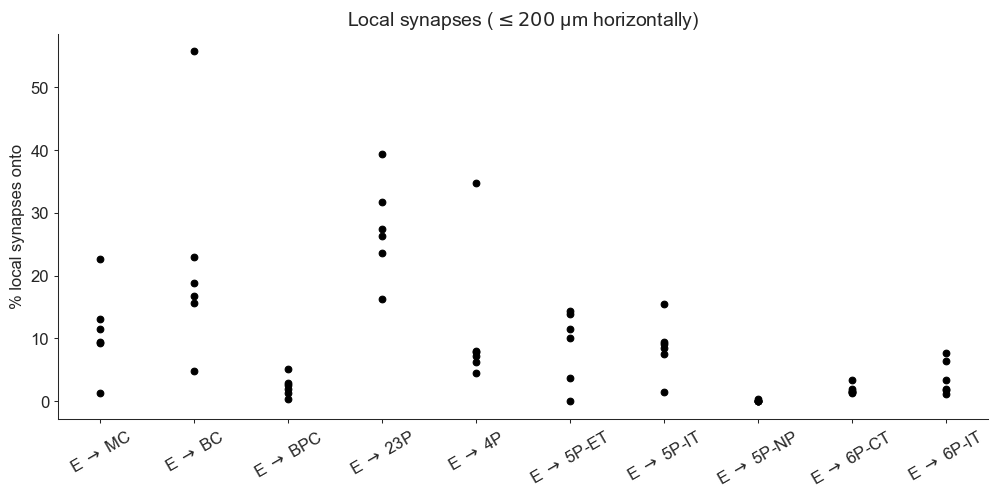

In [192]:
plt.figure(figsize=(12, 5))
for i, c in enumerate(cell_types):
    fracs = syn_frac_onto_cell_type[get_cell_type_str(c)]

    for frac in fracs:
        plt.scatter(i, frac*100, color="black")

plt.xticks(ticks=range(len(cell_types)), labels=[f"{get_cell_type_str(pre_cell_type)} $\\rightarrow$ {get_cell_type_str(c)}" for c in cell_types], rotation=30)
plt.ylabel("% local synapses onto")
plt.title(f"Local synapses ($\leq {local_dist}$ µm horizontally)")